In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import pickle as pkl
import multiprocessing as mp
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
concs = [5.0, 10.0, 20.0, 30.0, 40.0]
oligomersizes = np.arange(4, 61, 2)
MATH_type='MATHfree'
Ka_scan_rough = np.logspace(-12, 12, num=12)
nr_Ka_scan_fine = [10, 10, 10]
chi2_fit_isodesmicKd = 1.24

In [3]:
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

#Loads experimental SAXS q, I and err - in BME format
def load_exp_SAXS(exp_file):
    q, I, err = np.genfromtxt(exp_file, usecols=(0,1,2), skip_header=0, unpack=True)
    return np.array(q), np.array(I), np.array(err)

#Loads SAXS intensities calculated from simulations - in BME format
def load_sim_SAXS(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    return np.array(calc_data)

def get_chi2(Iaverage_sim, I_exp, err_exp):
    
    chi2 = np.average(np.square((Iaverage_sim-I_exp)/err_exp))
    
    return chi2

#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value

In [4]:
#Function to calculate average SAXS from an equilibirum of SPOP dimer and a single oligomer
def SAXS_dimer_avg(I_oligomer, I_dimer, c_oligomer, c_dimer, size):
    
    #Get volume weight of dimer and oligomer
    volw_dimer = c_dimer/(c_dimer + (size/2)*c_oligomer)
    volw_oligomer = ((size/2)*c_oligomer)/(c_dimer + (size/2)*c_oligomer)
    
    #Calculate average SAXS data with scale and offset
    I_avg = (volw_dimer*I_dimer + volw_oligomer*I_oligomer)

    return I_avg

In [5]:
def optimize_c_dimer(Ka_target, ctot_dimer, size, nr_rough, nr_fine):
    
    c_dimer_start = 1e-20
    
    #Rough scan
    for c_dimer in np.linspace(c_dimer_start, ctot_dimer, num=nr_rough):
        
        #Get oligomer concentration based on dimer conc. and ctot
        c_oligomer = -(c_dimer-ctot_dimer)/(size/2)

        #Get Ka from dimer and oligomer conc.
        Ka_test = c_oligomer/(c_dimer**(size/2))

        dKa = abs(Ka_target-Ka_test)

        if c_dimer == c_dimer_start:
            dKa_min = dKa
            c_dimer_min = c_dimer

        if dKa < dKa_min:
            dKa_min = dKa
            c_dimer_min = c_dimer
            c_dimer_min_prev = c_dimer_prev
            
        c_dimer_prev = c_dimer

    #Finer scan
    fine_scan_start = c_dimer_min_prev
    fine_scan_end = c_dimer_min + c_dimer_min - c_dimer_min_prev
    
    for c_dimer in np.linspace(fine_scan_start, fine_scan_end, num=nr_fine):

        #Get oligomer concentration based on dimer conc. and ctot
        c_oligomer = -(c_dimer-ctot_dimer)/(size/2)

        #Get Ka from dimer and oligomer conc.
        Ka_test = c_oligomer/(c_dimer**(size/2))

        dKa = abs(Ka_target-Ka_test)

        if dKa < dKa_min:
            dKa_min = dKa
            c_dimer_min = c_dimer
            
    return c_dimer_min

# Scan Ka

In [6]:
def scan_Ka(size):
    #Load oligomer SAXS data and average
    I_oligomer = load_sim_SAXS(f'calc_data_{MATH_type}/calc_data_{size}mer.dat')
    I_oligomer = np.average(I_oligomer, axis=0)
    
    print(f'Starting rough scan for {size}mer')
    chi2_global_vs_Ka = []
    for n,Ka_target in enumerate(Ka_scan_rough):
                
        chi2_global=0
        for i,conc in enumerate(concs):
            
            ctot_dimer=conc/2.0

            c_dimer = optimize_c_dimer(Ka_target, ctot_dimer, size, int(10e3), int(10e5))

            #Get oligomer concentration based on dimer conc. and ctot
            c_oligomer = -(c_dimer-ctot_dimer)/(size/2)

            #Get Ka from dimer and oligomer conc.
            Ka_real = c_oligomer/(c_dimer**(size/2))

            #print(f'Ka_target: {Ka_target} \nKa_real: {Ka_real}')
                
            I_avg = SAXS_dimer_avg(I_oligomer, I_dimer, c_oligomer, c_dimer, size)
            
            I_avg_fit, slope, intercept, r_value = fit_scale_offset(I_avg, Iexp_vs_concs[i], err_exp_vs_concs[i])

            chi2 = get_chi2(I_avg_fit, Iexp_vs_concs[i], err_exp_vs_concs[i])
            
            chi2_global += chi2
        chi2_global /= len(concs)
        
        if n == 0:
            chi2_global_min = chi2_global
            Ka_min = Ka_target
            Ka_min_prev = Ka_target

        if chi2_global < chi2_global_min:
            chi2_global_min = chi2_global
            Ka_min = Ka_target
            Ka_min_prev = Ka_prev
        
        Ka_prev = Ka_target
        
    #Run finer scans
    for fine_scan_iteration,nr in enumerate(nr_Ka_scan_fine):
        fine_scan_start = Ka_min_prev
        fine_scan_end = Ka_min + Ka_min - Ka_min_prev
        
        print(f'Starting fine scan {fine_scan_iteration+1} for {size}mer')
        Ka_scan_fine = np.linspace(fine_scan_start, fine_scan_end, num=nr)
        for n,Ka_target in enumerate(Ka_scan_fine):
            
            chi2_global=0
            for i,conc in enumerate(concs):

                ctot_dimer=conc/2.0

                c_dimer = optimize_c_dimer(Ka_target, ctot_dimer, size, int(10e3), int(10e5))

                #Get oligomer concentration based on dimer conc. and ctot
                c_oligomer = -(c_dimer-ctot_dimer)/(size/2)

                #Get Ka from dimer and oligomer conc.
                Ka_real = c_oligomer/(c_dimer**(size/2))

                #print(f'Ka_target: {Ka_target} \nKa_real: {Ka_real}')

                I_avg = SAXS_dimer_avg(I_oligomer, I_dimer, c_oligomer, c_dimer, size)

                I_avg_fit, slope, intercept, r_value = fit_scale_offset(I_avg, Iexp_vs_concs[i], err_exp_vs_concs[i])

                chi2 = get_chi2(I_avg_fit, Iexp_vs_concs[i], err_exp_vs_concs[i])

                chi2_global += chi2
            chi2_global /= len(concs)

            if n == 0:
                chi2_global_min = chi2_global
                Ka_min = Ka_target
                Ka_min_prev = Ka_target

            if chi2_global < chi2_global_min:
                chi2_global_min = chi2_global
                Ka_min = Ka_target
                Ka_min_prev = Ka_prev

            Ka_prev = Ka_target
    
    results = np.array([Ka_min, chi2_global_min])
    return results

In [7]:
Iexp_vs_concs = []
err_exp_vs_concs = []
for conc in concs:
    exp_file = f'WT_{MATH_type}_scaleoffsetonly/exp_data_{conc}uM.dat'
    q, Iexp, err_exp = load_exp_SAXS(exp_file)
    Iexp_vs_concs.append(Iexp)
    err_exp_vs_concs.append(err_exp)
Iexp_vs_concs = np.array(Iexp_vs_concs)
err_exp_vs_concs = np.array(err_exp_vs_concs)

#Load dimer simulation SAXS data and average
I_dimer = load_sim_SAXS(f'calc_data_{MATH_type}/calc_data_2mer.dat')
I_dimer = np.average(I_dimer, axis=0)

pool = mp.Pool(len(oligomersizes))
Ka_and_chi2_min_vs_size = pool.map(scan_Ka, oligomersizes)
pool.close()
pool.join()

Ka_and_chi2_min_vs_size = np.array(Ka_and_chi2_min_vs_size)
save_pickle('pickles/Ka_and_chi2_min_vs_size.pkl', Ka_and_chi2_min_vs_size)

Starting rough scan for 48mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 38merStarting rough scan for 50mer



/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 32mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 44mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 40merStarting rough scan for 46merStarting rough scan for 36mer



/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 28mer

Starting rough scan for 30merStarting rough scan for 34mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 12mer
Starting rough scan for 16mer
Starting rough scan for 56mer
Starting rough scan for 22mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 10mer
Starting rough scan for 26mer
Starting rough scan for 8merStarting rough scan for 52mer



/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 58mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 4mer
Starting rough scan for 6mer
Starting rough scan for 18mer
Starting rough scan for 24mer
Starting rough scan for 54mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 42mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting rough scan for 14mer
Starting rough scan for 20mer
Starting rough scan for 60mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

Starting fine scan 1 for 4mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

Starting fine scan 1 for 20mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 58mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 14mer
Starting fine scan 1 for 24mer
Starting fine scan 1 for 26mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 44mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 36mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 52mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 56mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 40mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 38mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 50mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 6mer
Starting fine scan 1 for 42mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 28mer
Starting fine scan 1 for 54mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 12mer
Starting fine scan 1 for 18mer
Starting fine scan 1 for 16mer
Starting fine scan 1 for 32mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 34mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 46mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 22mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 10mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 8mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 60mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 48mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 1 for 30mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 2 for 4mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 2 for 20mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 58mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 2 for 14mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 36mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 42mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 44mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

Starting fine scan 2 for 26mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 52mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 40mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 6mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 24mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 56mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 2 for 28mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 54mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 50mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 38mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 34mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 2 for 18mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 32mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 12mer
Starting fine scan 2 for 16mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 46mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 2 for 22mer
Starting fine scan 2 for 8mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 10mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 30mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 2 for 60mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

Starting fine scan 2 for 48mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 3 for 4mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 3 for 58mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

Starting fine scan 3 for 14mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 44mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 3 for 42mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 52mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 3 for 36mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 3 for 20mer
Starting fine scan 3 for 40mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 6mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

Starting fine scan 3 for 54mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 28mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 3 for 24mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 56mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 50mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 26mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 38mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 34mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

Starting fine scan 3 for 46mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 3 for 32mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 16mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

Starting fine scan 3 for 60mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 8mer
Starting fine scan 3 for 18mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

Starting fine scan 3 for 12mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 30mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 10mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Starting fine scan 3 for 22mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

Starting fine scan 3 for 48mer


/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/sit

# Analysis

In [9]:
Ka_and_chi2_min_vs_size = load_pickle('pickles/Ka_and_chi2_min_vs_size.pkl')

In [10]:
print(Ka_and_chi2_min_vs_size)

[[1.06554205e+15 1.41931822e+01]
 [1.06812688e+15 3.19208031e+00]
 [1.06813762e+15 2.00277880e+00]
 [7.17599126e+00 1.65606626e+00]
 [4.14526868e+01 1.49789526e+00]
 [3.08366882e+02 1.99598906e+00]
 [1.18575942e+00 1.55146141e+00]
 [2.61535014e+00 1.76273798e+00]
 [1.14633127e+00 1.71005913e+00]
 [1.11399070e+00 1.99948292e+00]
 [8.10070971e-03 1.45894326e+00]
 [6.93277984e-03 1.50911003e+00]
 [2.22513042e-03 1.49083048e+00]
 [3.37643426e-04 1.46917249e+00]
 [4.84483700e-04 1.55894096e+00]
 [2.28012272e-04 1.63447576e+00]
 [7.34986833e-05 1.64571406e+00]
 [1.82651268e-05 1.95540725e+00]
 [1.85989551e-07 1.55431374e+00]
 [1.04586456e-06 1.73569455e+00]
 [3.50600009e-07 1.82587258e+00]
 [8.33088545e-08 1.77625430e+00]
 [2.94600372e-08 1.79707976e+00]
 [1.12268044e-08 1.86116998e+00]
 [2.61372060e-09 1.81542112e+00]
 [1.19542717e-09 1.84547563e+00]
 [5.00764049e-10 1.86302306e+00]
 [2.11031399e-10 1.86128567e+00]
 [5.45937536e-11 1.87579830e+00]]


In [11]:
Ka_min_vs_size = Ka_and_chi2_min_vs_size[...,0]
chi2_min_vs_size = Ka_and_chi2_min_vs_size[...,1]

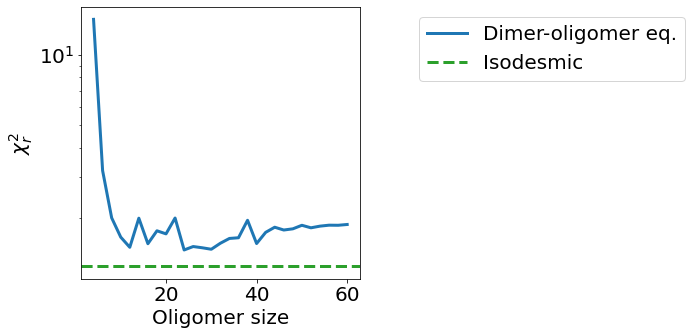

In [12]:
fig = plt.figure(figsize=(5,5))

plt.plot(oligomersizes, chi2_min_vs_size, '-', lw=3, c=colors[0], label='Dimer-oligomer eq.')
plt.axhline(chi2_fit_isodesmicKd, ls='--', lw=3, c=colors[2], label='Isodesmic')

plt.xlabel('Oligomer size', fontsize=20)
plt.ylabel('$\chi^2_r$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

#Legend
plt.legend(fontsize=20, ncol=1, bbox_to_anchor=(2.2, 1.0))
plt.semilogy()

fig.savefig(f"plots/two_species_eq_chi2global_vs_size.pdf", bbox_inches='tight', pad_inches=1)

# Check pure oligomers

In [13]:
Iexp_vs_concs = []
err_exp_vs_concs = []
for conc in concs:
    exp_file = f'WT_{MATH_type}_scaleoffsetonly/exp_data_{conc}uM.dat'
    q, Iexp, err_exp = load_exp_SAXS(exp_file)
    Iexp_vs_concs.append(Iexp)
    err_exp_vs_concs.append(err_exp)
Iexp_vs_concs = np.array(Iexp_vs_concs)
err_exp_vs_concs = np.array(err_exp_vs_concs)

In [14]:
oligomersizes_withdimer = np.arange(2, 61, 2)

chi2_vs_conc_vs_size = []
for size in oligomersizes_withdimer:
    #Load oligomer SAXS data and average
    I_oligomer = load_sim_SAXS(f'calc_data_{MATH_type}/calc_data_{size}mer.dat')
    I_oligomer = np.average(I_oligomer, axis=0)
    
    chi2_vs_conc=[]
    for i,conc in enumerate(concs):
        I_avg_fit, slope, intercept, r_value = fit_scale_offset(I_oligomer, Iexp_vs_concs[i], err_exp_vs_concs[i])
        chi2 = get_chi2(I_avg_fit, Iexp_vs_concs[i], err_exp_vs_concs[i])
        chi2_vs_conc.append(chi2)
    
    chi2_vs_conc_vs_size.append(chi2_vs_conc)
chi2_vs_conc_vs_size = np.array(chi2_vs_conc_vs_size)
chi2_global_vs_size = np.average(chi2_vs_conc_vs_size, axis=1)

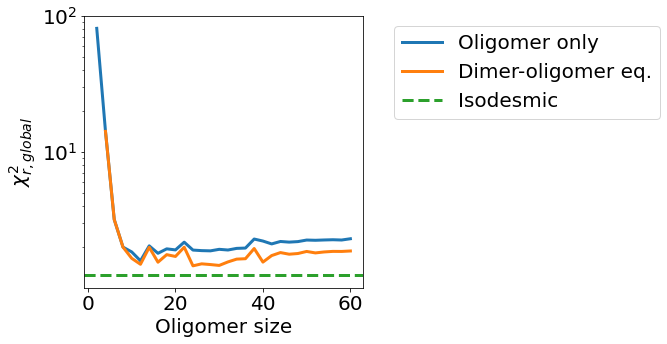

In [15]:
# Plot chi2 global
chi2_global_fit_isodesmicKd = 1.24

fig = plt.figure(figsize=(5,5))

plt.plot(oligomersizes_withdimer, chi2_global_vs_size, '-', lw=3, c=colors[0], label='Oligomer only')
plt.plot(oligomersizes, chi2_min_vs_size, '-', lw=3, c=colors[1], label='Dimer-oligomer eq.')
plt.axhline(chi2_global_fit_isodesmicKd, ls='--', lw=3, c=colors[2], label='Isodesmic')

#plt.title('Global fit to SAXS series', fontsize=20)

plt.xlabel('Oligomer size', fontsize=20)
plt.ylabel('$\chi^2_{r,global}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

#Legend
plt.legend(fontsize=20, ncol=1, bbox_to_anchor=(2.1, 1.0))
plt.semilogy()

fig.savefig(f"plots/singleoligomer_and_two_species_eq_chi2global_vs_size.pdf", bbox_inches='tight', pad_inches=1)

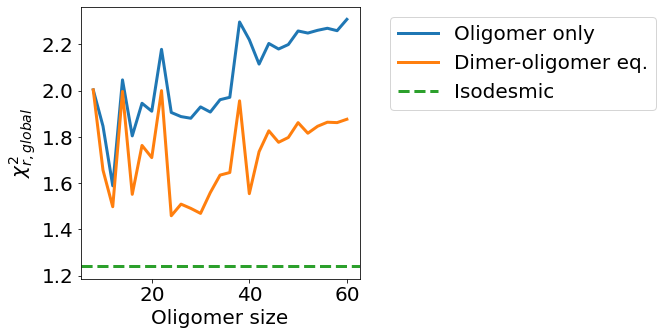

In [16]:
# Plot chi2 global
chi2_global_fit_isodesmicKd = 1.24

fig = plt.figure(figsize=(5,5))

plt.plot(oligomersizes_withdimer[3:], chi2_global_vs_size[3:], '-', lw=3, c=colors[0], label='Oligomer only')
plt.plot(oligomersizes[2:], chi2_min_vs_size[2:], '-', lw=3, c=colors[1], label='Dimer-oligomer eq.')
plt.axhline(chi2_global_fit_isodesmicKd, ls='--', lw=3, c=colors[2], label='Isodesmic')

#plt.title('Global fit to SAXS series', fontsize=20)

plt.xlabel('Oligomer size', fontsize=20)
plt.ylabel('$\chi^2_{r,global}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

#Legend
plt.legend(fontsize=20, ncol=1, bbox_to_anchor=(2.1, 1.0))

fig.savefig(f"plots/singleoligomer_and_two_species_eq_chi2global_vs_size_fromoctamer.pdf", bbox_inches='tight', pad_inches=1)